In [4]:
import os
from pathlib import Path
from typing import Tuple, Dict, List
from PIL import Image
import zipfile
import requests
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import random

In [2]:
os.listdir('/kaggle/input/')

['chest_xray']

In [5]:
import requests
import zipfile
from pathlib import Path

EPOCHS = 50
LEARNING_RATE = 0.005
BATCH_SIZE = 128 #32
INPUT_SHAPE = (60, 60) #(60, 60) #(224, 224, 3)
SEED = 100

#DATA_PATH_2 = Path("/kaggle/input/chest-xray-pneumonia/chest_xray") 
DATA_PATH_2 = Path("/kaggle/input/chest_xray")
NUM_WORKERS = os.cpu_count()
os.listdir('/kaggle/input/')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [3]:
import requests
import zipfile
from pathlib import Path

EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 128 #32
INPUT_SHAPE = (200, 200) #(60, 60) #(224, 224, 3)
SEED = 100

DATA_PATH_2 = Path("/kaggle/input/chest-xray-pneumonia/chest_xray") 
NUM_WORKERS = os.cpu_count()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [6]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((60, 60)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor(), # use ToTensor() last to get everything between 0 & 1
    transforms.Normalize(mean=[0.4465], std=[0.2716])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Don't need to perform augmentation on the test data
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((60, 60)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4471], std=[0.2701])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((60, 60)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4536], std=[0.2713])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((200, 200)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor(), # use ToTensor() last to get everything between 0 & 1
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Don't need to perform augmentation on the test data
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((200, 200)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((200, 200)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
TRAIN_PATH = DATA_PATH_2 / "train/"
#VAL_PATH = DATA_PATH_2 / "val/"
ELECTED_PATH = DATA_PATH_2 / "val/" #избрачные фото понадобятся в приложении

TEST_PATH = DATA_PATH_2 / "test/"

print(f"Path to train part of dataset: {TRAIN_PATH}.\n")
print(f"Path to elected part of dataset: {ELECTED_PATH}.\n") 
print(f"Path to test part of dataset: {TEST_PATH}\n")

Path to train part of dataset: /kaggle/input/chest_xray/train.

Path to elected part of dataset: /kaggle/input/chest_xray/val.

Path to test part of dataset: /kaggle/input/chest_xray/test



In [18]:
print(TRAIN_PATH.exists())

True


In [9]:
# load test data
train_set = datasets.ImageFolder(root=str(TRAIN_PATH), transform=train_transforms, target_transform=None)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

#val_set = datasets.ImageFolder(root=str(VAL_PATH), transform=test_transforms)      #, target_transform=None)
#val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

test_set = datasets.ImageFolder(root=str(TEST_PATH), transform=test_transforms)    #, target_transform=None)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

#print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")
#print(f"Train data:\n{train_set}\nValidation data:\n{val_set}Test data:\n{test_set}\n")
#print(f"All data:\n{all_set}")

print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

Creating DataLoader's with batch size 128 and 4 workers.


In [10]:
# Get class names as a list
class_names = train_set.classes
class_names

['NORMAL', 'PNEUMONIA']

In [11]:
# Can also get class names as a dict
class_dict = train_set.class_to_idx
class_dict

{'NORMAL': 0, 'PNEUMONIA': 1}

In [19]:
merged_set = datasets.ImageFolder(root=str(TRAIN_PATH), transform=train_transforms) +  datasets.ImageFolder(root=str(TEST_PATH), transform=test_transforms)

dataset_size = len(merged_set)
train_size = int(dataset_size * 0.7) # 70% на обучение
val_size = int(dataset_size * 0.2) # 20% на валидацию
test_size = dataset_size - train_size - val_size # 10% на тестирование

# разбиваем датасет на три выборки
train_set, val_set, test_set = torch.utils.data.random_split(merged_set, [train_size, val_size, test_size])

# создаем DataLoader для каждой выборки
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

print(f"Train data:\n{train_set}\nValidation data:\n{val_set}\nTest data:\n{test_set}\n")

Train data:
Validation data:
Test data:



In [13]:
len(train_set), len(val_set), len(test_set)

NameError: name 'val_set' is not defined

In [28]:
print(f"Len train data: {len(train_set)}\nLen validation data: {len(val_set)}\nLen test data: {len(test_set)}\n")

Len train data: 4087
Len validation data: 1168
Len test data: 585



------------------


DATA VISUALIZATION



------------------

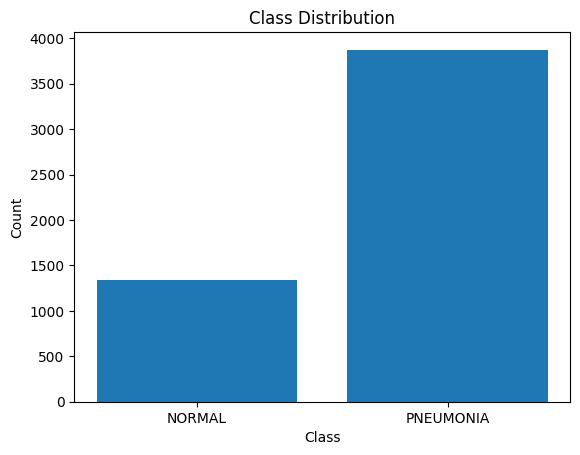

In [17]:
class_names = train_set.classes
class_counts = [0] * len(class_names)
for image, label in train_set:
    class_counts[label] += 1

# Рисуем гистограмму распределения классов
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [20]:
class_names = train_set.classes
class_counts = [0] * len(class_names)
for image, label in train_set:
    class_counts[label] += 1

# Рисуем гистограмму распределения классов
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

AttributeError: 'Subset' object has no attribute 'classes'

In [21]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#объявление функции для получения  confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Эта функция выводит и отображает матрицу ошибок.
    Нормализация может быть применена путем установки "normalize=True"
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Определяем все метки из тестовых данных
dataiter = iter(testloader)
images, labels = dataiter.next()

# Сохраняем все предсказанные метки
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Вычисляем confusion matrix
cm = confusion_matrix(labels, predicted)
np.set_printoptions(precision=2)

# Выводим confusion matrix
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cm, classes)

IndentationError: unexpected indent (3553268227.py, line 24)

In [22]:
_train_set = datasets.ImageFolder(root=str(TRAIN_PATH))
img, label = _train_set[1]
class_names = _train_set.classes
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=1422x1152>, 0, 'NORMAL')

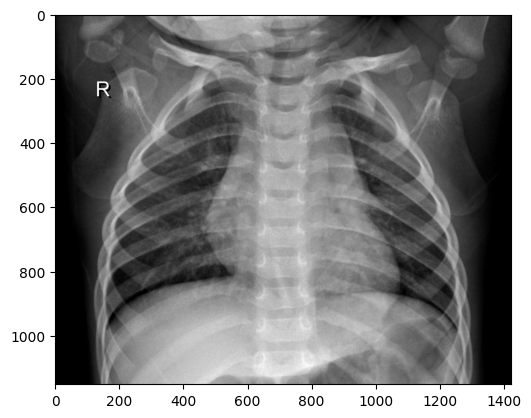

In [23]:
plt.imshow(img)
plt.show()

In [24]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
print(img_t.shape, img_t.dtype)

torch.Size([3, 1152, 1422]) torch.float32


In [56]:
print(img_t.min(), img_t.max())

tensor(0.) tensor(1.)


_____________

DATA ANALYSIS

_____________

In [25]:
images_train = torch.stack([img_t for img_t, _ in train_set], dim=3)
print(images_train.shape)


images_val = torch.stack([img_t for img_t, _ in val_set], dim=3)
print(images_val.shape)

images_test = torch.stack([img_t for img_t, _ in test_set], dim=3)
print(images_test.shape)

torch.Size([1, 60, 60, 4087])
torch.Size([1, 60, 60, 1168])
torch.Size([1, 60, 60, 585])


In [26]:
print(f"Train set mean: {  images_train.view(-1).mean(dim=0, keepdim=True)  }")
print(f"Val set mean: {  images_val.view(-1).mean(dim=0, keepdim=True)  }")
print(f"Test set mean: {  images_test.view(-1).mean(dim=0, keepdim=True)  }")

Train set mean: tensor([-0.0025])
Val set mean: tensor([0.0003])
Test set mean: tensor([0.0268])


In [59]:
print(f"Train set median: {  images_train.view(-1).median(dim=0, keepdim=True) }")
print(f"Val set median: {  images_val.view(-1).median(dim=0, keepdim=True)  }")
print(f"Test set median: {  images_test.view(-1).median(dim=0, keepdim=True)  }")

Train set median: torch.return_types.median(
values=tensor([0.5216]),
indices=tensor([121058069]))
Val set median: torch.return_types.median(
values=tensor([0.5255]),
indices=tensor([11857450]))
Test set median: torch.return_types.median(
values=tensor([0.5255]),
indices=tensor([1359080]))


In [32]:
rounded_images_train = torch.round(images_train.float(), decimals = 2) 

print(f"Train set mean: {  images_train.mode() }")

Train set mean: torch.return_types.mode(
values=tensor([[[-1.6440, -1.6440, -1.6440,  ..., -1.6440, -1.6440, -1.6440],
         [-1.6440, -1.6440, -1.6440,  ..., -1.6440, -1.6440, -1.6440],
         [-1.6440, -1.6440, -1.6440,  ..., -1.6440, -1.6440, -1.6440],
         ...,
         [-1.6440, -1.6440, -1.6440,  ..., -1.6440, -1.6440, -1.6440],
         [-1.6440, -1.6440, -1.6440,  ..., -1.6440, -1.6440, -1.6440],
         [-1.6440, -1.6440, -1.6440,  ..., -1.6440, -1.6440, -1.6440]]]),
indices=tensor([[[  24,  682,  142,  ..., 3742, 3504,  129],
         [ 486,  352,  617,  ...,  633,  179, 3579],
         [ 806,  210,  582,  ..., 4044, 3924,  565],
         ...,
         [ 900, 1277, 1063,  ..., 3515,  430,   37],
         [1330, 1146,  445,  ...,  574, 1255,  125],
         [  59, 1174,  905,  ...,  657,  771,   12]]]))


In [34]:
rounded_images_train = torch.round(images_train, decimals = 4) 
rounded_images_val = torch.round(images_val, decimals = 4) 
rounded_images_test = torch.round(images_test, decimals = 4) 

print(f"Train set median: {  rounded_images_train.view(3,-1).mode(dim=0, keepdim=True) }")
print(f"Val set median: {  rounded_images_val.view(3,-1).mode(dim=0, keepdim=True)  }")
print(f"Test set median: {  rounded_images_test.view(3,-1).mode(dim=0, keepdim=True)  }")

Train set median: torch.return_types.mode(
values=tensor([[-1.6440, -1.1242, -1.6440,  ..., -0.8354, -1.6440, -1.6440]]),
indices=tensor([[2, 0, 2,  ..., 2, 2, 2]]))
Val set median: torch.return_types.mode(
values=tensor([[-1.6440, -1.6440, -1.6440,  ..., -0.7343, -1.6719, -1.6440]]),
indices=tensor([[2, 2, 2,  ..., 2, 2, 2]]))
Test set median: torch.return_types.mode(
values=tensor([[-1.3696, -0.5589, -1.6151,  ..., -1.6440,  0.7673, -1.6440]]),
indices=tensor([[2, 0, 1,  ..., 2, 0, 2]]))


In [36]:
print(f"Train set std: {  (images_train.view(-1).std(dim=0, keepdim=True))}")
print(f"Val set std: {  (images_val.view(-1).std(dim=0, keepdim=True))  }")
print(f"Test set std: {  (images_test.view(-1).std(dim=0, keepdim=True)) }")

Train set std: tensor([0.9954])
Val set std: tensor([0.9846])
Test set std: tensor([1.0099])


In [63]:
#Теперь вычислим значения среднего отклонения, стандартного отклонения, коэффициента корреляции и коэффициента ковариации для каждой из выборок. Используем метод view() для преобразования тензора images_train в тензор размером (3, N), где N - это общее количество пикселей во всех изображениях (ширина_изображения * высота_изображения * количество_изображений). Далее мы используем метод mean() с параметром dim=1 для вычисления среднего значения, метод std() для вычисления стандартного отклонения, метод corrcoef() и cov()  для вычисления коэффициентов корреляции и ковариации по каждому из трех цветовых каналов. Аналогичную операцию применим и к валидационной и тестовой выборке

#print(f"Train set mean: {  images_train.view(3, -1).mean(dim=1)  }")
#print(f"Val set mean: {  images_val.view(3, -1).mean(dim=1)  }")
#print(f"Test set mean: {  images_test.view(3, -1).mean(dim=1)  }")

In [37]:
# Приводим images_train к одномерному тензору:
gray_train = images_train.mean(dim=0, keepdim=True)
gray_train = gray_train[0].view(-1)

# Вычисляем среднее, медиану и моду:
mean = gray_train.mean()
median = torch.median(gray_train)
mode, _ = torch.mode(gray_train)

print(f"Среднее: {mean:.4f}")
print(f"Медиана: {median:.4f}")
print(f"Мода: {mode.item()}")

Среднее: -0.0025
Медиана: 0.1176
Мода: -1.6439616680145264


In [39]:
def torch_mode(tensor):
    values, counts = torch.unique(tensor, return_counts=True)
    ind = torch.argmax(counts)
    mode = values[ind]
    return mode.item()

In [40]:
#images_train = images_train.view(3, -1)
print(f"Train set mode: { torch_mode(images_train) }")

KeyboardInterrupt: 

In [41]:
print(f"Train set corr coef: {  images_train.view(3,-1).corrcoef() }")
print(f"Val set corr coef: {  images_val.view(3,-1).corrcoef() }")
print(f"Test set corr coef: {  images_test.view(3,-1).corrcoef() }")

Train set corr coef: tensor([[1.0000, 0.5696, 0.4877],
        [0.5696, 1.0000, 0.6529],
        [0.4877, 0.6529, 1.0000]])
Val set corr coef: tensor([[1.0000, 0.5622, 0.4686],
        [0.5622, 1.0000, 0.6426],
        [0.4686, 0.6426, 1.0000]])
Test set corr coef: tensor([[1.0000, 0.5826, 0.4935],
        [0.5826, 1.0000, 0.6489],
        [0.4935, 0.6489, 1.0000]])


In [42]:
print(f"Train set cov coef: {  images_train.view(3, -1).cov() }")
print(f"Val set cov coef: {  images_val.view(3, -1).cov() }")
print(f"Test set cov coef: {  images_test.view(3, -1).cov() }")

Train set cov coef: tensor([[0.8127, 0.4901, 0.4905],
        [0.4901, 0.9107, 0.6951],
        [0.4905, 0.6951, 1.2444]])
Val set cov coef: tensor([[0.8009, 0.4731, 0.4629],
        [0.4731, 0.8843, 0.6671],
        [0.4629, 0.6671, 1.2184]])
Test set cov coef: tensor([[0.8401, 0.5166, 0.5109],
        [0.5166, 0.9363, 0.7091],
        [0.5109, 0.7091, 1.2757]])


In [44]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

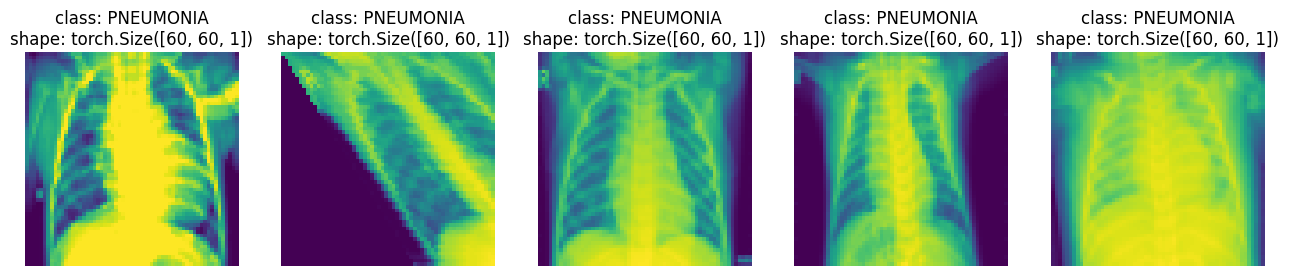

In [45]:
# Display random images from ImageFolder created Dataset
display_random_images(test_set, 
                      n=5, 
                      classes=class_names,
                      seed=None)

In [ ]:
class GrayScaleModel(nn.Module):  #SIZE(60, 60)
    def __init__(self) -> None:
        super(GrayScaleModel, self).__init__() 
       
        self.layer_1 = nn.Sequential(          
            ##Input = 3 x 100 x 100, Output = 16 x 50 x 50
            nn.Conv2d(in_channels=1,   #shape 1    # number of channels in the input image
                      out_channels=4,            # number of channels produced by the convolution
                      kernel_size=(3, 3),        # how big is the square that's going over the image?
                      stride=1,                  # default
                      padding=1),
            nn.BatchNorm2d(4),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )    
             
            
        self.layer_2 = nn.Sequential(    
            #Input = 16 x 50 x 50, Output = 16 x 25 x 25
            nn.Conv2d(in_channels=4, 
                      out_channels=8, 
                      kernel_size = (3,3), 
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) 
        ) 
     
        self.layer_3 = nn.Sequential(    
            #Input = 16 x 50 x 50, Output = 16 x 25 x 25
            nn.Conv2d(in_channels=8, 
                      out_channels=8, 
                      kernel_size = (3,3), 
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ###Add
        ) 

        
        
        self.fc_2 = nn.Sequential(  
            nn.Flatten(),  
            nn.Dropout(p=0.6),
            nn.Linear(in_features=3200, out_features=300),
            nn.ReLU()
        )
                 
        self.fc_4 = nn.Sequential(    
            nn.Linear(in_features=300, out_features=2),
            #nn.ReLU()
            #nn.Softmax(dim=1)
        )    
            
              
     
       
    def forward(self, x: torch.Tensor):
        out = self.layer_1(x)  
        out = self.layer_2(out)
        out = self.layer_3(out)
        #out = self.layer_4(out)
        #out = out.reshape(out.size(0), -1)
              
        #out = self.fc_1(out)
        out = self.fc_2(out)
        #out = self.fc_3(out)
        out = self.fc_4(out)

        #out = out.view(out.size(0), -1)
        print(x.shape)     
        return out

torch.manual_seed(100)
model_exemplar = GrayScaleModel().to(device)
model_exemplar

In [48]:
class EightModel(nn.Module):  #SIZE(60, 60)
    def __init__(self) -> None:
        super(EightModel, self).__init__() 
       
        self.layer_1 = nn.Sequential(          
            ##Input = 3 x 100 x 100, Output = 16 x 50 x 50
            nn.Conv2d(in_channels=1,   #shape 1    # number of channels in the input image
                      out_channels=8,            # number of channels produced by the convolution
                      kernel_size=(3, 3),        # how big is the square that's going over the image?
                      stride=1,                  # default
                      padding=1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )    
             
            
        self.layer_2 = nn.Sequential(    
            #Input = 16 x 50 x 50, Output = 16 x 25 x 25
            nn.Conv2d(in_channels=8, 
                      out_channels=8, 
                      kernel_size = (3,3), 
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ###Add
        ) 
     

        
        
        self.fc_2 = nn.Sequential(  
            nn.Flatten(),  
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1800, out_features=100),
            nn.ReLU()
        )
                 
        self.fc_4 = nn.Sequential(    
            nn.Linear(in_features=100, out_features=2),
            #nn.ReLU()
            #nn.Softmax(dim=1)
        )    
            
              
     
       
    def forward(self, x: torch.Tensor):
        out = self.layer_1(x)  
        out = self.layer_2(out)
        #out = self.layer_3(out)
        #out = self.layer_4(out)
        #out = out.reshape(out.size(0), -1)
              
        #out = self.fc_1(out)
        out = self.fc_2(out)
        #out = self.fc_3(out)
        out = self.fc_4(out)

        #out = out.view(out.size(0), -1)
        #print(x.shape)     
        return out

torch.manual_seed(100)
model_exemplar = EightModel().to(device)
model_exemplar

EightModel(
  (layer_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=1800, out_features=100, bias=True)
    (3): ReLU()
  )
  (fc_4): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [ ]:
class EightModel(nn.Module):  #SIZE(60, 60)
    def __init__(self) -> None:
        super(EightModel, self).__init__() 
       
        self.layer_1 = nn.Sequential(          
            ##Input = 3 x 100 x 100, Output = 16 x 50 x 50
            nn.Conv2d(in_channels=1,   #shape 1    # number of channels in the input image
                      out_channels=8,            # number of channels produced by the convolution
                      kernel_size=(3, 3),        # how big is the square that's going over the image?
                      stride=1,                  # default
                      padding=1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )    
             
            
        self.layer_2 = nn.Sequential(    
            #Input = 16 x 50 x 50, Output = 16 x 25 x 25
            nn.Conv2d(in_channels=8, 
                      out_channels=8, 
                      kernel_size = (3,3), 
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ###Add
        ) 
     

        
        
        self.fc_2 = nn.Sequential(  
            nn.Flatten(),  
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1800, out_features=100),
            nn.ReLU()
        )
                 
        self.fc_4 = nn.Sequential(    
            nn.Linear(in_features=100, out_features=2),
            #nn.ReLU()
            #nn.Softmax(dim=1)
        )    
            
              
     
       
    def forward(self, x: torch.Tensor):
        out = self.layer_1(x)  
        out = self.layer_2(out)
        #out = self.layer_3(out)
        #out = self.layer_4(out)
        #out = out.reshape(out.size(0), -1)
              
        #out = self.fc_1(out)
        out = self.fc_2(out)
        #out = self.fc_3(out)
        out = self.fc_4(out)

        #out = out.view(out.size(0), -1)
        print(x.shape)     
        return out

torch.manual_seed(100)
model_exemplar = EightModel().to(device)
model_exemplar

In [ ]:
class CustomModel(nn.Module):
    def __init__(self) -> None:
        super(CustomModel, self).__init__() 
       
        self.layer_1 = nn.Sequential(          
            ##Input = 3 x 200 x 100, Output = 6 x 100 x 100
            nn.Conv2d(in_channels=1,   #shape 1    # number of channels in the input image
                      out_channels=6,            # number of channels produced by the convolution
                      kernel_size=(3, 3),        # how big is the square that's going over the image?
                      stride=1,                  # default
                      padding=1),
            nn.BatchNorm2d(6),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )    
             
            
        self.layer_2 = nn.Sequential(    
            #Input = 6 x 100 x 100, Output = 6 x 50 x 50
            nn.Conv2d(in_channels=6, 
                      out_channels=6, 
                      kernel_size = (3, 3), 
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ###Add
        ) 

        self.layer_3 = nn.Sequential(          
            ##Input = 6 x 50 x 50, Output = 12 x 25 x 25
            nn.Conv2d(in_channels=6,   #shape 1    # number of channels in the input image
                      out_channels=12,            # number of channels produced by the convolution
                      kernel_size=(3, 3),        # how big is the square that's going over the image?
                      stride=1,                  # default
                      padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )    
             
            
        self.layer_4 = nn.Sequential(    
            #Input = 12 x 25 x 25, Output = 12 x 12 x 12
            nn.Conv2d(in_channels=12, 
                      out_channels=12, 
                      kernel_size = (3,3), 
                      stride = 1, 
                      padding = 1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ###Add
        ) 
     

        
        
        self.fc_1 = nn.Sequential(  
            nn.Flatten(),  
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1728, out_features=300),
            nn.ReLU()
        )

        self.fc_2 = nn.Sequential(           
            nn.Dropout(p=0.5),
            nn.Linear(in_features=300, out_features=60),
            nn.ReLU()
        )
                 
        self.fc_3 = nn.Sequential(    
            nn.Linear(in_features=60, out_features=2),
        )    
            
              
     
       
    def forward(self, x: torch.Tensor):
        out = self.layer_1(x)  
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        #out = out.reshape(out.size(0), -1)
              
        out = self.fc_1(out)
        out = self.fc_2(out)
        out = self.fc_3(out)
      

        #out = out.view(out.size(0), -1)
        #print(x.shape)     
        return out

torch.manual_seed(100)
model_exemplar = CustomModel().to(device)
model_exemplar

In [55]:
# create train loop function
def train_step_function(model: torch.nn.Module,
                        dataloader: torch.utils.data.DataLoader,
                        loss_fn: torch.nn.Module,
                        optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_accuracy = 0, 0

    # Loop through data loader data batches
    for (batch, (X, y)) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_predict = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_predict, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_predict_class = torch.argmax(torch.softmax(y_predict, dim=1), dim=1)
        train_accuracy += (y_predict_class == y).sum().item()/len(y_predict)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    return train_loss, train_accuracy

In [56]:
def test_step_function(model: torch.nn.Module,
                       dataloader: torch.utils.data.DataLoader,
                       loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_accuracy = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for (batch, (X, y)) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_accuracy += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)
    return test_loss, test_accuracy

In [57]:
# create validation loop function
def validation_step_function(model: torch.nn.Module,
                             dataloader: torch.utils.data.DataLoader,
                             loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_accuracy = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for (batch, (X, y)) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_accuracy += ((val_pred_labels == y).sum().item() / len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    return val_loss, val_accuracy

In [58]:
# 1. Take in various parameters required for training and test steps
from tqdm.auto import tqdm

def train_function(model: torch.nn.Module,
                   train_dataloader: torch.utils.data.DataLoader,
                   validation_dataloader: torch.utils.data.DataLoader,
                   test_dataloader: torch.utils.data.DataLoader,
                   optimizer: torch.optim.Optimizer,
                   loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                   epochs: int = 50):            # int = 5):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_accuracy": [],
               "val_loss": [],
               "val_accuracy": [],
               "test_loss": [],
               "test_accuracy": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step_function(model=model,
                                                         dataloader=train_dataloader,
                                                         loss_fn=loss_fn,
                                                         optimizer=optimizer)

        val_loss, val_accuracy = validation_step_function(model=model,
                                                          dataloader=validation_dataloader,
                                                          loss_fn=loss_fn)

        test_loss, test_accuracy = test_step_function(model=model,
                                                      dataloader=test_dataloader,
                                                      loss_fn=loss_fn)

        # 4. Print out what's happening
        # print(
        #    f"Epoch: {epoch + 1} | "
        #    f"train_loss: {train_loss:.4f} | "
        #    f"train_accuracy: {train_accuracy:.4f} | "
        #    f"val_loss: {val_loss:.4f} | "
        #    f"val_accuracy: {val_accuracy:.4f} | "
        #    f"test_loss: {test_loss:.4f} | "
        #    f"test_accuracy: {test_accuracy:.4f}"
        # )
        
        print(f"Epoch: {epoch + 1} | train_loss: {train_loss:.4f} | train_accuracy: {train_accuracy:.4f} | val_loss: {val_loss:.4f} | val_accuracy: {val_accuracy:.4f} | test_loss: {test_loss:.4f} | test_accuracy: {test_accuracy:.4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["val_loss"].append(val_loss)
        results["val_accuracy"].append(val_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set random seeds
torch.manual_seed(100)

# Set number of epochs
EPOCHS = 15

# Recreate an instance of FirstModel   create a exemplar of model class
model_exemplar = EightModel()  # 2 classes
print(model_exemplar)
#print(summary(model_exemplar, input_size=[1, 3, 200, 200]))  # do a test pass through of an example input size

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_exemplar.parameters(), lr=LEARNING_RATE)    # lr=0.001)
#optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_first
model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# Set random seeds
torch.manual_seed(100)

# Set number of epochs
EPOCHS = 14

# Recreate an instance of FirstModel   create a exemplar of model class
model_exemplar = EightModel()  # 2 classes

print(model_exemplar)
#print(summary(model_exemplar, input_size=[1, 3, 200, 200]))  # do a test pass through of an example input size

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_exemplar.parameters(), lr=LEARNING_RATE)    # lr=0.001)
#optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_first
model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
# Set random seeds
torch.manual_seed(100)

# Set number of epochs
EPOCHS = 14

# Recreate an instance of FirstModel   create a exemplar of model class
model_exemplar = EightModel()  # 2 classes
#print(model_exemplar)
#print(summary(model_exemplar, input_size=[1, 3, 200, 200]))  # do a test pass through of an example input size

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params=model_exemplar.parameters(), lr=LEARNING_RATE)    # lr=0.001)
optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_first
model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
model_exemplar_results.keys()

In [59]:
def plot_loss_acc(results: Dict[str, List[float]]):
    
    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_accuracy']
    test_accuracy = results['test_accuracy']
    val_accuracy = results['val_accuracy']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    

In [ ]:
plot_loss_acc(model_exemplar_results)

In [ ]:
# Set random seeds
torch.manual_seed(100)

# Set number of epochs
EPOCHS = 26

# Recreate an instance of FirstModel   create a exemplar of model class
model_exemplar_2 = EightModel()  # 2 classes
#print(model_exemplar)
#print(summary(model_exemplar, input_size=[1, 3, 200, 200]))  # do a test pass through of an example input size

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params=model_exemplar.parameters(), lr=LEARNING_RATE)    # lr=0.001)
optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_first
model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
def plot_loss_acc(results: Dict[str, List[float]]):
    
    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_accuracy']
    test_accuracy = results['test_accuracy']
    val_accuracy = results['val_accuracy']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_acc(model_exemplar_results)

In [ ]:
import pandas as pd
model_exemplar_df = pd.DataFrame(model_exemplar_results)

model_exemplar_df

In [ ]:
# Set random seeds
torch.manual_seed(100)

# Set number of epochs
EPOCHS = 50

# Recreate an instance of FirstModel   create a exemplar of model class
model_exemplar_3 = CustomModel()
# 2 classes
#print(model_exemplar)
#print(summary(model_exemplar, input_size=[1, 3, 200, 200]))  # do a test pass through of an example input size

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params=model_exemplar.parameters(), lr=LEARNING_RATE)    # lr=0.001)
optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_first
model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "pytorch_computer_vision_model_3_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_exemplar_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

TESTING

In [ ]:
torch.manual_seed(100)
EPOCHS = 100
model_exemplar_2 = EightModel()  # 2 classes

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5141 | train_accuracy: 0.7564 | val_loss: 0.5016 | val_accuracy: 0.7453 | test_loss: 0.5170 | test_accuracy: 0.7202


In [18]:
torch.manual_seed(100)
EPOCHS = 100
model_exemplar_2 = EightModel()  # 2 classes

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5777 | train_accuracy: 0.7158 | val_loss: 0.5436 | val_accuracy: 0.7430 | test_loss: 0.5492 | test_accuracy: 0.7292
Epoch: 2 | train_loss: 0.5161 | train_accuracy: 0.7578 | val_loss: 0.4931 | val_accuracy: 0.7406 | test_loss: 0.5134 | test_accuracy: 0.7308
Epoch: 3 | train_loss: 0.4752 | train_accuracy: 0.7802 | val_loss: 0.4628 | val_accuracy: 0.7594 | test_loss: 0.4695 | test_accuracy: 0.7620
Epoch: 4 | train_loss: 0.4472 | train_accuracy: 0.8022 | val_loss: 0.4679 | val_accuracy: 0.7508 | test_loss: 0.4369 | test_accuracy: 0.7738
Epoch: 5 | train_loss: 0.4193 | train_accuracy: 0.8167 | val_loss: 0.4191 | val_accuracy: 0.8125 | test_loss: 0.4239 | test_accuracy: 0.7862
Epoch: 6 | train_loss: 0.3923 | train_accuracy: 0.8276 | val_loss: 0.4305 | val_accuracy: 0.7937 | test_loss: 0.3753 | test_accuracy: 0.8163
Epoch: 7 | train_loss: 0.3833 | train_accuracy: 0.8410 | val_loss: 0.3759 | val_accuracy: 0.8242 | test_loss: 0.3665 | test_accuracy: 0.8433
Epoch: 8 | tr

In [25]:
torch.manual_seed(100)
EPOCHS = 17
model_exemplar_2 = EightModel()  # 2 classes

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_exemplar.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_exemplar_results = train_function(model=model_exemplar,
                                     train_dataloader=train_loader,
                                     validation_dataloader=val_loader,
                                     test_dataloader=test_loader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5775 | train_accuracy: 0.7205 | val_loss: 0.5852 | val_accuracy: 0.7008 | test_loss: 0.5461 | test_accuracy: 0.7374
Epoch: 2 | train_loss: 0.5232 | train_accuracy: 0.7547 | val_loss: 0.5181 | val_accuracy: 0.7203 | test_loss: 0.5122 | test_accuracy: 0.7409
Epoch: 3 | train_loss: 0.4742 | train_accuracy: 0.7811 | val_loss: 0.4804 | val_accuracy: 0.7523 | test_loss: 0.4666 | test_accuracy: 0.7581
Epoch: 4 | train_loss: 0.4416 | train_accuracy: 0.8086 | val_loss: 0.4685 | val_accuracy: 0.7492 | test_loss: 0.4517 | test_accuracy: 0.7777
Epoch: 5 | train_loss: 0.4267 | train_accuracy: 0.8127 | val_loss: 0.4213 | val_accuracy: 0.7953 | test_loss: 0.4478 | test_accuracy: 0.7604
Epoch: 6 | train_loss: 0.4000 | train_accuracy: 0.8318 | val_loss: 0.4311 | val_accuracy: 0.7719 | test_loss: 0.4223 | test_accuracy: 0.7886
Epoch: 7 | train_loss: 0.3856 | train_accuracy: 0.8364 | val_loss: 0.3772 | val_accuracy: 0.8266 | test_loss: 0.3719 | test_accuracy: 0.8409
Epoch: 8 | tr

In [31]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "pytorch_computer_vision_model_4_0_normalise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_exemplar_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_computer_vision_model_4_0_normalise.pth


In [2]:

import torch

tensor = torch.tensor([[0.4346, 0.5118]])
tensor = tensor.squeeze()

difference = tensor[1] - tensor[0]
print(difference)

tensor(0.0772)
